# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.mlemodel import MLEResults
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# Load the Data

In [2]:
# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Set the frequency of the time series data
data.index = data.index.to_period('M')

# Display the data
data.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


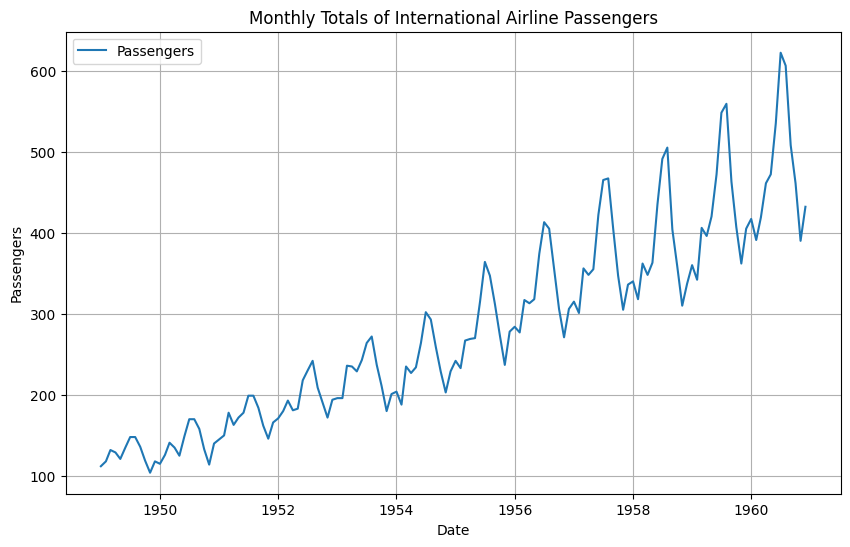

In [3]:
# Convert the PeriodIndex to DatetimeIndex for plotting
data.index = data.index.to_timestamp()

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.plot(data, label='Passengers')
plt.title('Monthly Totals of International Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Prepare the Data

In [4]:
# Split data into train and test sets (80% train, 20% test)
y = data['Passengers']
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Fit the Model

In [5]:
# Specify the Structural Time Series Model (Unobserved Components Model)
# Components: Level (trend), Seasonal (monthly), and Irregular
model = UnobservedComponents(
    train,
    level='local linear trend',  # Can use 'local level' or 'random walk' as well
    seasonal=12,  # 12 months per year for seasonality
    freq_seasonal=[{'period': 12, 'harmonics': 2}],  # Fourier seasonal harmonics
)

# Fit the model
fit_model = model.fit(disp=False)
print(fit_model.summary())

                                Unobserved Components Results                                
Dep. Variable:                            Passengers   No. Observations:                  115
Model:                            local linear trend   Log Likelihood                -360.098
                           + stochastic seasonal(12)   AIC                            730.196
                   + stochastic freq_seasonal(12(2))   BIC                            743.121
Date:                               Wed, 11 Sep 2024   HQIC                           735.424
Time:                                       07:53:12                                         
Sample:                                   01-01-1949                                         
                                        - 07-01-1958                                         
Covariance Type:                                 opg                                         
                                 coef    std err          z 

# Diagnostics & Evaluation

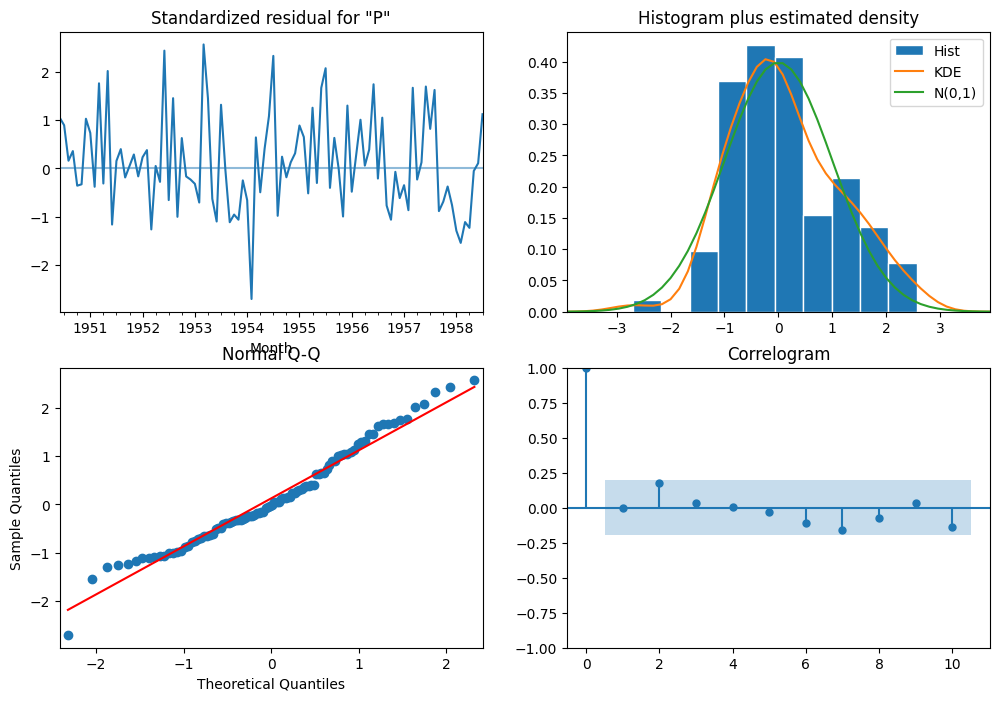

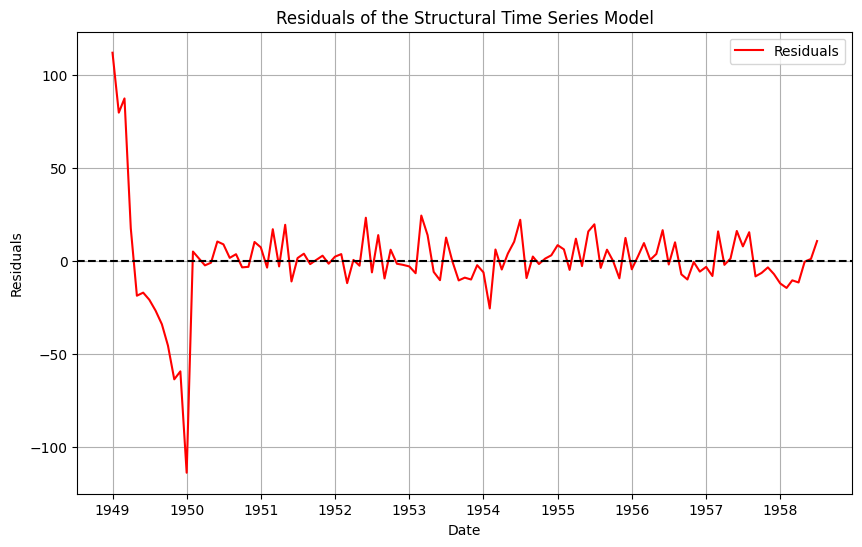

In [6]:
# Diagnostic plots to check residuals and model performance
fit_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Extract the residuals
residuals = fit_model.resid

# Plot residuals to check for unmodeled patterns
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals of the Structural Time Series Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

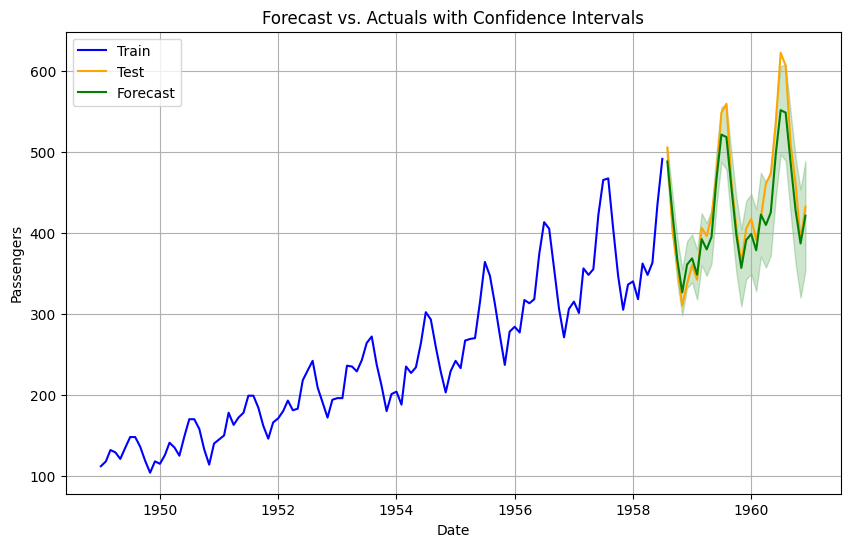

In [7]:
# Forecast for the length of the test set
n_forecast = len(test)
forecast_object = fit_model.get_forecast(steps=n_forecast)
forecast_mean = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

# Plot the forecast against actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='green', alpha=0.2)
plt.title('Forecast vs. Actuals with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Evaluate the forecast using MSE, RMSE, MAE, and MAPE metrics
mse = mean_squared_error(test, forecast_mean)
rmse = sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)
mape = mean_absolute_percentage_error(test, forecast_mean)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Squared Error (MSE): 778.6182771135245
Root Mean Squared Error (RMSE): 27.90373231511377
Mean Absolute Error (MAE): 21.935085176311823
Mean Absolute Percentage Error (MAPE): 0.04687413113587942


# RPy2 Workflow

In [9]:
!pip install -q rpy2

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import contextlib
import io
import os
from IPython.display import Image, display, HTML
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import r, pandas2ri, DataFrame
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import FloatVector, StrVector
import rpy2.robjects.lib.grdevices as grdevices
import rpy2.ipython.html

# Enable R printing
rpy2.ipython.html.init_printing()

# Enable automatic DataFrame conversion
pandas2ri.activate()

In [11]:
# Function to install and import R packages
def manage_r_packages(packages):
    """
    Installs missing R packages and imports them into Python.

    Parameters:
    packages (list): List of R package names to check, install, and import.

    Returns:
    dict: Dictionary of imported R packages.
    """
    missing_packages = []
    installed_packages = {}

    # Check which packages are already installed and install missing ones
    for package_name in packages:
        try:
            installed_packages[package_name] = importr(package_name)
            print(f"{package_name} is already installed and imported.")
        except PackageNotInstalledError:
            missing_packages.append(package_name)

    # If there are missing packages, install them
    if missing_packages:
        print(f"Installing missing packages: {missing_packages}")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with contextlib.redirect_stdout(None):
                utils.install_packages(StrVector(missing_packages), quiet=True)

        # Import newly installed packages
        for package_name in missing_packages:
            try:
                installed_packages[package_name] = importr(package_name)
                print(f"Successfully installed and imported {package_name}.")
            except Exception as e:
                print(f"Failed to import {package_name} after installation: {str(e)}")
    else:
        print("All required packages are already installed and imported.")

    return installed_packages

In [12]:
# List of required R packages
required_packages = ['forecast', 'lazyeval', 'ggplot2', 'tseries', 'Metrics']

# Install and import required R packages
importr('base')
importr('utils')
r_packages = manage_r_packages(required_packages)

ggplot2 is already installed and imported.
Installing missing packages: ['forecast', 'lazyeval', 'tseries', 'Metrics']


In [13]:
# Convert Pandas DataFrame into an R DataFrame using ro.DataFrame
r_df = ro.DataFrame(data)

# Add the R DataFrame to the global environment
ro.globalenv['airline_df'] = r_df

In [14]:
# Ensure the output directory exists
output_dir = "/content/output_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
# Structural Time Series Analysis
r_script = """
# Load necessary libraries
library(forecast)
library(ggplot2)
library(tseries)

# Helper function to manually compute forecast metrics
calculate_metrics <- function(actual, forecast) {
  # Mean Squared Error
  mse <- mean((actual - forecast)^2)

  # Root Mean Squared Error
  rmse <- sqrt(mse)

  # Mean Absolute Error
  mae <- mean(abs(actual - forecast))

  # Mean Absolute Percentage Error (MAPE)
  mape <- mean(abs((actual - forecast) / actual)) * 100

  return(list(
    MSE = mse,
    RMSE = rmse,
    MAE = mae,
    MAPE = mape
  ))
}

# Convert the dataset to a time series object
airline_ts <- ts(airline_df$Passengers, start = c(1949, 1), frequency = 12)

# Split the data: use data up to 1957 for training, and 1958-1960 for testing
train_ts <- window(airline_ts, end=c(1957,12))
test_ts <- window(airline_ts, start=c(1958,1))

# Perform STL decomposition on the training data
stl_decomp <- stl(train_ts, s.window = "periodic")

# Plot the STL decomposition
decomposition_plot_path <- '/content/output_plots/decomposition_plot.png'
p1 <- autoplot(stl_decomp) + ggtitle('STL Decomposition of Airline Passengers Data') + theme_minimal()
ggsave(filename=decomposition_plot_path, plot=p1, width=8, height=6, dpi=100)

# Fit a state-space model (using ETS - Exponential Smoothing State Space) on the training data
ets_model <- ets(train_ts)

# Forecast future values (24 months ahead) using the trained model
forecast_values <- forecast(ets_model, h=24)

# Extract the mean forecast (point forecasts) for accuracy calculation
forecast_mean <- forecast_values$mean

# Plot the forecast along with the historical data
forecast_plot_path <- '/content/output_plots/forecast_plot.png'
p2 <- autoplot(forecast_values) + ggtitle('Forecast of Airline Passengers Data (1958-1960)') + theme_minimal()
ggsave(filename=forecast_plot_path, plot=p2, width=8, height=6, dpi=100)

# Test residuals for autocorrelation (to ensure good model fit)
residuals_plot_path <- '/content/output_plots/residuals_plot.png'
p3 <- checkresiduals(ets_model)
ggsave(filename=residuals_plot_path, width=8, height=6, dpi=100)

# Model diagnostics
aic_value <- AIC(ets_model)
bic_value <- BIC(ets_model)
ljung_box_test <- Box.test(residuals(ets_model), lag=20, type="Ljung-Box")
diagnostics <- list(
  AIC = aic_value,
  BIC = bic_value,
  Ljung_Box_Q = ljung_box_test$statistic,
  Ljung_Box_p_value = ljung_box_test$p.value
)

# Manually compute forecast accuracy metrics (comparing test set to forecasted values)
manual_metrics <- calculate_metrics(test_ts, forecast_mean)

# Return the fitted model summary, diagnostics, and forecast results
list(
  summary = summary(ets_model),
  diagnostics = diagnostics,
  manual_metrics = manual_metrics,
  forecast_values = forecast_values
)
"""

# Run the R script in Python
results = r(r_script)


	Ljung-Box test

data:  Residuals from ETS(M,Ad,M)
Q* = 21.04, df = 22, p-value = 0.5183

Model df: 0.   Total lags used: 22



In [16]:
# Extract results from the R script
model_summary = results[0]
diagnostics = results[1]
manual_metrics = results[2]
forecast_values = results[3]

In [17]:
# Print the model summary
print("Model Summary:")
print(model_summary)

Model Summary:
ETS(M,Ad,M) 

Call:
ets(y = train_ts)

  Smoothing parameters:
    alpha = 0.7111 
    beta  = 0.0325 
    gamma = 1e-04 
    phi   = 0.9761 

  Initial states:
    l = 120.2635 
    b = 1.7949 
    s = 0.9017 0.7973 0.9168 1.0575 1.1954 1.2104
           1.1035 0.9791 0.9922 1.0324 0.9041 0.9097

  sigma:  0.0371

      AIC      AICc       BIC 
 971.6821  979.3675 1019.9605 

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 1.201866 7.587831 6.083293 0.4111097 2.749102 0.1989765 0.09484279



In [18]:
# Print the diagnostics information
print("Model Diagnostics:")
print(f"AIC: {diagnostics[0]}")
print(f"BIC: {diagnostics[1]}")
print(f"Ljung-Box Q-statistic: {diagnostics[2]}")
print(f"Ljung-Box p-value: {diagnostics[3]}")

Model Diagnostics:
AIC: [971.6820967]
BIC: [1019.96045878]
Ljung-Box Q-statistic: [19.68173732]
Ljung-Box p-value: [0.47799018]


In [19]:
# Print the metrics
print("Forecast Accuracy Metrics:")
print(f"MSE (Mean Squared Error): {manual_metrics[0]}")
print(f"RMSE (Root Mean Squared Error): {manual_metrics[1]}")
print(f"MAE (Mean Absolute Error): {manual_metrics[2]}")
print(f"MAPE (Mean Absolute Percentage Error): {manual_metrics[3]}")

Forecast Accuracy Metrics:
MSE (Mean Squared Error): [913.63913732]
RMSE (Root Mean Squared Error): [30.22646419]
MAE (Mean Absolute Error): [23.62163619]
MAPE (Mean Absolute Percentage Error): [5.54418265]


Displaying STL decomposition plot:


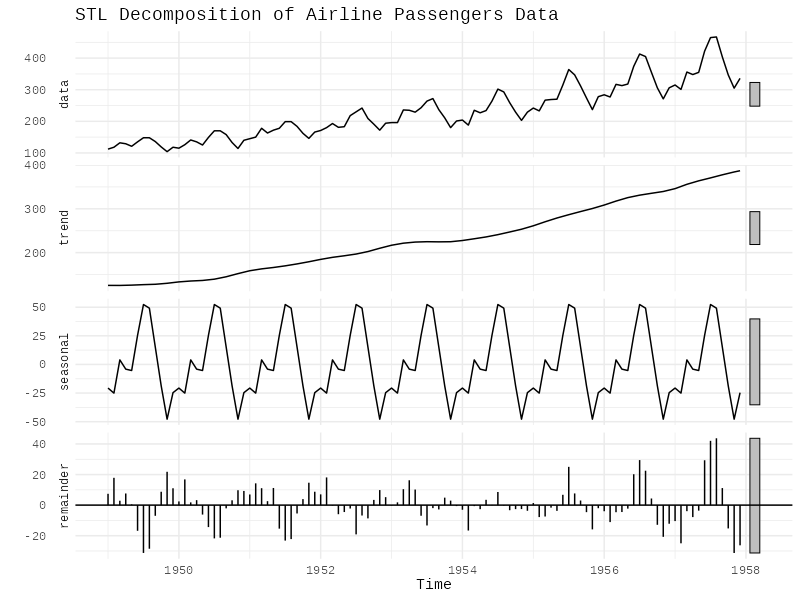

Displaying forecast plot:


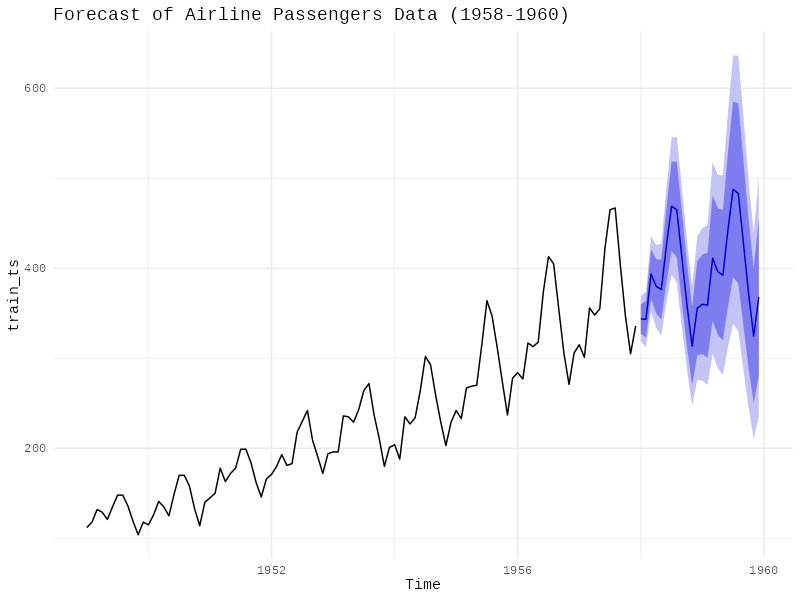


Displaying residuals plot:


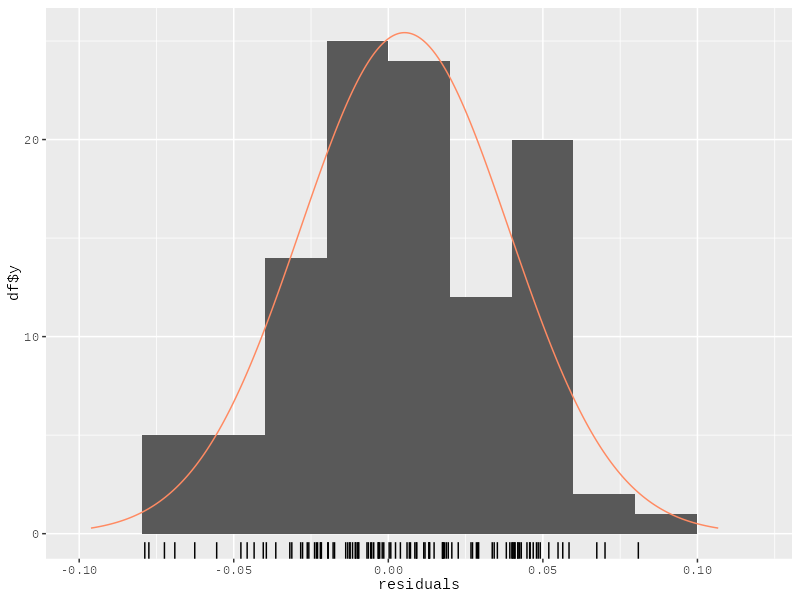

In [20]:
# Display the saved plots
output_dir = "/content/output_plots"

print("Displaying STL decomposition plot:")
stl_decomposition = os.path.join(output_dir, "decomposition_plot.png")
display(Image(filename=stl_decomposition))

print("Displaying forecast plot:")
forecast_plot = os.path.join(output_dir, "forecast_plot.png")
display(Image(filename=forecast_plot))

print("\nDisplaying residuals plot:")
residuals_plot = os.path.join(output_dir, "residuals_plot.png")
display(Image(filename=residuals_plot))

In [21]:
# Print forecasted values
print("Forecasted Values:")
print(forecast_values)

Forecasted Values:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1958       343.7906 327.4369 360.1442 318.7798 368.8014
Feb 1958       343.2124 322.8943 363.5306 312.1385 374.2864
Mar 1958       393.6299 366.2324 421.0273 351.7291 435.5306
Apr 1958       379.9023 349.7892 410.0154 333.8482 425.9563
May 1958       376.4291 343.1391 409.7191 325.5164 427.3417
Jun 1958       425.9388 384.5134 467.3643 362.5841 489.2936
Jul 1958       469.0367 419.4050 518.6683 393.1316 544.9417
Aug 1958       464.9819 411.8930 518.0709 383.7894 546.1744
Sep 1958       412.8265 362.3079 463.3452 335.5649 490.0882
Oct 1958       359.1787 312.3268 406.0306 287.5249 430.8325
Nov 1958       313.4443 270.0624 356.8263 247.0974 379.7913
Dec 1958       355.6839 303.6558 407.7120 276.1138 435.2540
Jan 1959       360.0300 304.5590 415.5010 275.1944 444.8656
Feb 1959       358.9666 300.8849 417.0482 270.1384 447.7948
Mar 1959       411.1901 341.5044 480.8757 304.6151 517.7651
Apr 1959       396.37